# Baseline2：时间序列方法
本baseline主要展示如何用时间序列方法解决该比赛，主要特点为：
1. 使用了一些基本的时间序列特征构造方法
2. 以线性回归模型和树模型LightGBM为例训练模型
3. ensemble方法：模型预测结果融合
4. 基于先验信息调整预测结果

## 安装依赖

In [11]:
!pip install numpy pandas scikit-learn matplotlib seaborn lightgbm

## 导入相关包

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
plt.rcParams['font.sans-serif'] = ["WenQuanYi Micro Hei",'SimHei']
plt.rcParams['axes.unicode_minus'] = False

base_path=Path("data")
train_length=55392

## 读取数据

In [13]:
electricity_price=pd.read_csv(base_path/"electricity_price_parsed.csv",parse_dates=["timestamp"],index_col=0)
electricity_price.columns=["demand","price"]
sample_submit=pd.read_csv(base_path/"sample_submit.csv")

train_data=electricity_price.copy(deep=True)
electricity_price.head()

,demand,price
timestamp,,
2021-12-01 00:15:00,40334.18,350.80
2021-12-01 00:30:00,40523.15,350.80
2021-12-01 00:45:00,40374.74,350.80
2021-12-01 01:00:00,40111.55,350.80
2021-12-01 01:15:00,40067.50,348.93


# 特征工程

特征工程是数据预处理过程的一部分，涉及从原始数据中提取和创建新特征，以提高机器学习模型的性能。它包括清理数据、处理缺失值、转换变量类型、标准化或归一化数据，以及创建新的衍生特征。特征工程的目标是通过选择和构建合适的特征，使模型能够更好地理解数据和预测目标变量。

详细的时间序列特征工程构造方法可以参考第二期Datawhale电力预测夏令营：https://datawhaler.feishu.cn/wiki/G8WywyV8iiYtuGkVjoOchdjxnib

In [14]:
# 将电价数据的时间索引信息添加到训练数据中

# 提取时间索引的小时信息，并添加到训练数据中，创建 "hour" 列
train_data["hour"] = electricity_price.index.hour

# 提取时间索引的日期信息，并添加到训练数据中，创建 "day" 列
train_data["day"] = electricity_price.index.day

# 提取时间索引的月份信息，并添加到训练数据中，创建 "month" 列
train_data["month"] = electricity_price.index.month

# 提取时间索引的年份信息，并添加到训练数据中，创建 "year" 列
train_data["year"] = electricity_price.index.year

# 提取时间索引的星期信息，并添加到训练数据中，创建 "weekday" 列
train_data["weekday"] = electricity_price.index.weekday

# 根据月份信息，判断是否为风季（1-5月和9-12月），创建布尔型 "is_windy_season" 列
train_data["is_windy_season"] = electricity_price.index.month.isin([1, 2, 3, 4, 5, 9, 10, 11, 12])

# 根据小时信息，判断是否为低谷时段（10-15点），创建布尔型 "is_valley" 列
train_data["is_valley"] = electricity_price.index.hour.isin([10, 11, 12, 13, 14, 15])

# 提取时间索引的季度信息，并添加到训练数据中，创建 "quarter" 列
train_data["quarter"] = electricity_price.index.quarter

# 对时间特征进行独热编码（One-Hot Encoding），删除第一列以避免多重共线性
train_data = pd.get_dummies(
    data=train_data,        # 需要进行独热编码的 DataFrame
    columns=["hour", "day", "month", "year", "weekday"],  # 需要独热编码的列
    drop_first=True         # 删除第一列以避免多重共线性
)


### 节假日特征

基于Task2中的EDA，我们发现节假日中电力价格更容易为负值，因此我们构造典型的春节和劳动节的节假日特征。当然你也可以尝试构造其他的节假日特征（端午节、清明节、国庆节……）

> 可以使用python的holidays库来构造节假日特征，但考虑到其给出的日期范围不够准确，所以这里进行了手动构造

In [15]:
def generate_holiday_dates(start_dates, duration):
    """
    生成一系列节假日日期列表。

    参数：
    start_dates (list): 节假日开始日期的列表，格式为字符串，例如 ["2022-01-31", "2023-01-21"]。
    duration (int): 每个节假日的持续天数。

    返回：
    list: 包含所有节假日日期的列表。
    """
    holidays = []  # 初始化一个空列表，用于存储节假日日期
    for start_date in start_dates:  # 遍历每个节假日的开始日期
        # 生成从 start_date 开始的日期范围，持续时间为 duration 天
        holidays.extend(pd.date_range(start=start_date, periods=duration).tolist())
    return holidays  # 返回所有节假日日期的列表

# 春节的开始日期列表
spring_festival_start_dates = ["2022-01-31", "2023-01-21", "2024-02-10"]

# 劳动节的开始日期列表
labor_start_dates = ["2022-04-30", "2023-04-29"]

# 生成春节的所有日期，持续时间为 7 天
spring_festivals = generate_holiday_dates(spring_festival_start_dates, 7)

# 生成劳动节的所有日期，持续时间为 5 天
labor = generate_holiday_dates(labor_start_dates, 5)


In [16]:
spring_festivals[:5]

[Timestamp('2022-01-31 00:00:00'),
 Timestamp('2022-02-01 00:00:00'),
 Timestamp('2022-02-02 00:00:00'),
 Timestamp('2022-02-03 00:00:00'),
 Timestamp('2022-02-04 00:00:00')]

In [17]:
# 判断训练数据的索引是否在春节日期列表中，生成布尔型列 "is_spring_festival"
train_data["is_spring_festival"] = train_data.index.isin(spring_festivals)

# 判断训练数据的索引是否在劳动节日期列表中，生成布尔型列 "is_labor"
train_data["is_labor"] = train_data.index.isin(labor)


### 构造基于demand的窗口特征
可以发现一段时间内，总负荷如果有下降趋势，则下一个出清价格也可能下降。因此联想到构造基于总需求的窗口特征。

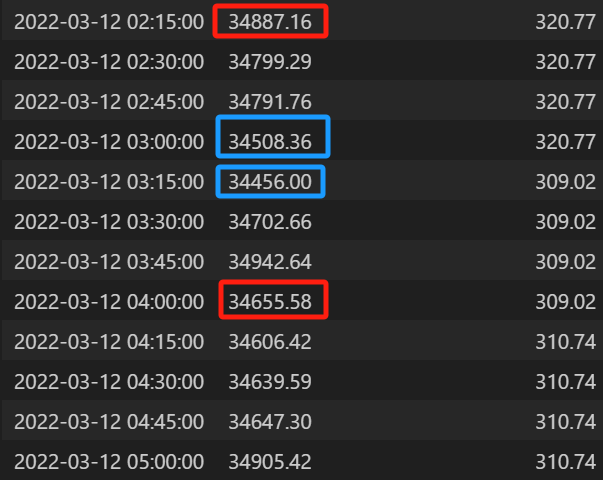

In [18]:
def cal_range(x):
    """
    计算极差（最大值和最小值之差）。

    参数：
    x (pd.Series): 输入的时间序列数据。

    返回：
    float: 极差值。

    示例：
    >>> import pandas as pd
    >>> x = pd.Series([1, 2, 3, 4, 5])
    >>> cal_range(x)
    4
    """
    return x.max() - x.min()


def increase_num(x):
    """
    计算序列中发生增长的次数。

    参数：
    x (pd.Series): 输入的时间序列数据。

    返回：
    int: 序列中增长的次数。

    示例：
    >>> x = pd.Series([1, 2, 3, 2, 4])
    >>> increase_num(x)
    3
    """
    return (x.diff() > 0).sum()


def decrease_num(x):
    """
    计算序列中发生下降的次数。

    参数：
    x (pd.Series): 输入的时间序列数据。

    返回：
    int: 序列中下降的次数。

    示例：
    >>> x = pd.Series([1, 2, 1, 3, 2])
    >>> decrease_num(x)
    2
    """
    return (x.diff() < 0).sum()


def increase_mean(x):
    """
    计算序列中上升部分的均值。

    参数：
    x (pd.Series): 输入的时间序列数据。

    返回：
    float: 序列中上升部分的均值。

    示例：
    >>> x = pd.Series([1, 2, 3, 2, 4])
    >>> diff = x.diff()
    >>> diff
    0    NaN
    1    1.0
    2    1.0
    3   -1.0
    4    2.0
    dtype: float64
    >>> increase_mean(x)
    1.33
    """
    diff = x.diff()
    return diff[diff > 0].mean()


def decrease_mean(x):
    """
    计算序列中下降的均值（取绝对值）。

    参数：
    x (pd.Series): 输入的时间序列数据。

    返回：
    float: 序列中下降的均值（绝对值）。

    示例：
    >>> import pandas as pd
    >>> x = pd.Series([4, 3, 5, 2, 6])
    >>> decrease_mean(x)
    2.0
    """
    diff = x.diff()
    return diff[diff < 0].abs().mean()


def increase_std(x):
    """
    计算序列中上升部分的标准差。

    参数：
    x (pd.Series): 输入的时间序列数据。

    返回：
    float: 序列中上升部分的标准差。

    示例：
    >>> import pandas as pd
    >>> x = pd.Series([1, 2, 3, 2, 4])
    >>> increase_std(x)
    0.5773502691896257
    """
    diff = x.diff()
    return diff[diff > 0].std()


def decrease_std(x):
    """
    计算序列中下降部分的标准差。

    参数：
    x (pd.Series): 输入的时间序列数据。

    返回：
    float: 序列中下降部分的标准差。

    示例：
    >>> import pandas as pd
    >>> x = pd.Series([4, 3, 5, 2, 6])
    >>> decrease_std(x)
    1.4142135623730951
    """
    diff = x.diff()
    return diff[diff < 0].std()


In [19]:
from tqdm import tqdm  # 导入 tqdm 库用于显示进度条

# 定义滚动窗口大小的列表
window_sizes = [4, 12, 24]

# 遍历每个窗口大小
with tqdm(window_sizes) as pbar:
    for window_size in pbar:
        # 定义要应用的聚合函数列表
        functions = ["mean", "std", "min", "max", cal_range, increase_num,
                     decrease_num, increase_mean, decrease_mean, increase_std, decrease_std]

        # 遍历每个聚合函数
        for func in functions:
            # 获取函数名称，如果是字符串则直接使用，否则使用函数的 __name__ 属性
            func_name = func if type(func) == str else func.__name__

            # 生成新列名，格式为 demand_rolling_{window_size}_{func_name}
            column_name = f"demand_rolling_{window_size}_{func_name}"

            # 计算滚动窗口的聚合值，并将结果添加到 train_data 中
            train_data[column_name] = train_data["demand"].rolling(
                window=window_size,        # 滚动窗口大小
                min_periods=window_size//2,  # 最小观测值数
                closed="left"         # 滚动窗口在左侧闭合
            ).agg(func)              # 应用聚合函数

            pbar.set_postfix({"window_size": window_size, "func": func_name})


100%|██████████| 3/3 [03:13<00:00, 64.60s/it, window_size=24, func=decrease_std] 


### 其他时序特征
### 其他时序特征

1. **`shift` 方法**
    - **描述**: 将序列中的值向前或向后移动指定的位数，填充移位后产生的缺失值。
    - **语法**: `Series.shift(periods=1, freq=None, axis=0, fill_value=None)`
    - **参数**:
        - `periods`：移位的时期数，正数表示向后移位，负数表示向前移位。
        - `freq`：时间间隔或时间偏移量，可选。
        - `axis`：要移动的轴，默认为0。
        - `fill_value`：移位后填充缺失值的值，可选。
    - **示例**:
        ```python
        import pandas as pd
        demand = pd.Series([10, 20, 30, 40])
        demand_shift_1 = demand.shift(1)
        print(demand_shift_1)
        # 输出：
        # 0     NaN
        # 1    10.0
        # 2    20.0
        # 3    30.0
        # dtype: float64
        ```

2. **`diff` 方法**
    - **描述**: 计算序列中相邻值之间的差异，结果是当前值减去前一个值。
    - **语法**: `Series.diff(periods=1, axis=0)`
    - **参数**:
        - `periods`：要计算差异的时期数，默认为1。
        - `axis`：要计算差异的轴，默认为0。
    - **示例**:
        ```python
        import pandas as pd
        demand = pd.Series([10, 20, 30, 40])
        demand_diff_1 = demand.diff(1)
        print(demand_diff_1)
        # 输出：
        # 0    NaN
        # 1    10.0
        # 2    10.0
        # 3    10.0
        # dtype: float64
        ```

3. **`pct_change` 方法**
    - **描述**: 计算序列中相邻值的百分比变化，结果是当前值减去前一个值再除以前一个值。
    - **语法**: `Series.pct_change(periods=1, fill_method='pad', limit=None, freq=None)`
    - **参数**:
        - `periods`：要计算百分比变化的时期数，默认为1。
        - `fill_method`：用于填充缺失值的方法（如 'pad' 或 'bfill'），默认为 'pad'。
        - `limit`：填充时的最大数量，可选。
        - `freq`：时间间隔或时间偏移量，可选。
    - **示例**:
        ```python
        import pandas as pd
        demand = pd.Series([10, 20, 30, 40])
        demand_pct_1 = demand.pct_change(1)
        print(demand_pct_1)
        # 输出：
        # 0         NaN
        # 1    1.000000
        # 2    0.500000
        # 3    0.333333
        # dtype: float64
        ```


In [20]:
# 添加新的特征列：demand_shift_1，表示将 demand 列中的值向后移动一位
# shift(1) 的结果是当前行的值等于前一行的值，第一行的值为 NaN
train_data["demand_shift_1"] = train_data["demand"].shift(1)

# 添加新的特征列：demand_diff_1，表示 demand 列中相邻值的差
# diff(1) 的结果是当前行的值减去前一行的值，第一行的值为 NaN
train_data["demand_diff_1"] = train_data["demand"].diff(1)

# 添加新的特征列：demand_pct_1，表示 demand 列中相邻值的百分比变化
# pct_change(1) 的结果是当前行的值减去前一行的值再除以前一行的值，第一行的值为 NaN
train_data["demand_pct_1"] = train_data["demand"].pct_change(1)


这里我们使用`bfill()`和`ffill()`主要因为获取时序特征会形成缺失值，比如我们将数据平移一层，那么第一个值由于没有前面的值，就会变为`NaN`，即缺失值。当然你可以使用其他缺失值填充方式（KNN插值、线性插值、模型预测缺失值）

本例中我们使用最简单的基于时序的填充方法。

In [21]:
# 从 train_data 中创建训练集和测试集特征数据 (X) 和目标数据 (y)

# 创建训练集特征数据 X_train
# 1. 从 train_data 中选择前 train_length 行，去除 "price" 列
# 2. 使用 bfill 方法向后填充缺失值
# 3. 使用 ffill 方法向前填充缺失值
X_train = train_data.iloc[:train_length].drop(columns=["price"]).bfill().ffill()

# 创建测试集特征数据 X_test
X_test = train_data.iloc[train_length:].drop(columns=["price"]).bfill().ffill()

# 创建训练集目标数据 y_train
y_train = train_data.iloc[:train_length][["price"]]



一般数据科学比赛中，线性模型和树模型是比较常用的两种回归模型，在这里我们将**线性回归**和**LightGBM**作为Baseline的两个模型，并不进行特别的超参数调优。

可以尝试其他模型例如：
- 基于深度学习的方法：LSTM、NBeats、Transformer……
- 基于时序模型的方法：ARIMA、Prophet、VARMAX……
- 其他线性模型：Ridge、ElasticNet、Lasso……
- 其他树模型：CatBoost、XGBoost、LightGBM

In [22]:
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

# 创建 LGBMRegressor 模型对象，设置参数
# num_leaves：树的叶子数，控制模型复杂度
# n_estimators：迭代次数，即树的数量
# verbose：日志信息级别，-1 表示不输出日志信息
lgb_model = LGBMRegressor(num_leaves=2**5-1, n_estimators=300, verbose=-1)

# 创建线性回归模型对象
linear_model = LinearRegression()

# 使用训练集数据训练 LGBMRegressor 模型
# X_train：训练集特征数据
# y_train：训练集目标数据
lgb_model.fit(X_train, y_train)

# 使用训练集数据中的 "demand" 特征训练线性回归模型
# X_train[["demand"]]：训练集特征数据中仅包含 "demand" 列
# y_train：训练集目标数据
linear_model.fit(X_train[["demand"]], y_train)

# 使用训练好的 LGBMRegressor 模型预测测试集特征数据
# X_test：测试集特征数据
# 返回预测的目标值
lgb_pred = lgb_model.predict(X_test)

# 使用训练好的线性回归模型预测测试集特征数据中的 "demand" 列
# X_test[["demand"]]：测试集特征数据中仅包含 "demand" 列
# 返回预测的目标值，并将结果展平为一维数组
linear_pred = linear_model.predict(X_test[["demand"]]).flatten()

# 模型融合

考虑到demand对价格的线性程度高，但直接线性回归无法捕捉到时序中的一些非线性特征，因此我们融合树模型和线性模型的结果。

此外还记得我们在Task2中提到，由于鸭子曲线，火电厂在低谷期时的价格会越来越低，并且整体火电价格也会下降，因此我们可以对最终预测结果进行一个整体上的缩放，保证符合未来的趋势。

In [23]:
# 简单求均值
y_pred = (lgb_pred+linear_pred)/2
y_pred *= 0.95  # 进行少量修正

成功后就可以提交到官网啦：http://competition.sais.com.cn/competitionDetail/532232/mySubmissions

最终结果应该是11302.0459左右，当然你可以尝试加入线下验证来寻找更优的模型融合和系数修正方法

> ps：在本次赛题数据中，线下验证的效果和线上验证效果差别非常大，思考当测试集分布和训练集分布不一致时，应该如何优化自己的模型

In [24]:
sample_submit["clearing price (CNY/MWh)"] = y_pred
sample_submit.head()

,day,time,clearing price (CNY/MWh)
0,2023/7/1,0:15,391.704814
1,2023/7/1,0:30,386.056237
2,2023/7/1,0:45,379.044964
3,2023/7/1,1:00,376.880418
4,2023/7/1,1:15,382.486849


In [25]:
sample_submit.to_csv("submit.csv", index=False)